# Projet 5 - Segmentez les clients d'un site e-commerce

# Contrat de Maintenance

# 1- Importation du jeu de données et des librairies utiles

In [1]:
#Importation des librairies de visualisation
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#Importation des librairies de manipulation des données
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

#Importation de la librairie os pour la gestion des différents fichiers
import os

#Importation des modules de réduction dimensionnelle non superviée de scikit-learn
from sklearn.decomposition import FactorAnalysis

#Importation de l'algorithme KMeans
from sklearn.cluster import KMeans

#Importation des librairie de preprocessing
from sklearn.preprocessing import StandardScaler

#Importation des librairies metrics
from sklearn.metrics import adjusted_rand_score

In [2]:
#Nos jeux de données sont disponibles dans le répertoire de travail, nous pouvons les placer dans une liste

Data_list = []
for i in os.listdir():
    if 'olist' in i:
        Data_list.append(i)
Data_list

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv']

In [3]:
#Nous créeons dynamiquement 8 jeux de données en bouclant sur notre liste de jeux de données, que nous placons
#dans une liste

Datasets = []
for i in range(len(Data_list)):
    temp = Data_list[i][6:-12]
    locals()[temp] = pd.read_csv(Data_list[i])
    print(temp)
    Datasets.append(locals()[temp])

customers
geolocation
orders
order_items
order_payments
order_reviews
products
sellers


In [4]:
#Nous commencons par changer le type des colonnes de date 

for i in orders.columns[3:]:
    orders[i] = pd.to_datetime(orders[i], 
                               format = "%Y-%m-%d %H:%M:%S")
print(orders.dtypes)

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


# 2- Définition de la fonction RFM_builder

In [5]:
#Construction de la fonction RFM_builder permettant de retourner le jeu de données avec les features RFM

def RFM_builder(orders, customers, order_payments, date):
    
    date = datetime.strptime(date, '%y/%m/%d %H:%M:%S')
    #Features utiles dans chaque df
    df_orders = orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
    df_customers = customers[['customer_id', 'customer_unique_id']]
    df_payments = order_payments[['order_id', 'payment_value']]
    
    #construction jeu de données RFM
    t0 = orders.loc[orders['order_purchase_timestamp'] < date]
    Most_Recent_Date = t0['order_purchase_timestamp'].max()
    data = customers.merge(t0, left_on = 'customer_id', 
                           right_on = 'customer_id', 
                           how = 'right')

    init = data[['customer_unique_id', 'order_purchase_timestamp']].sort_values(by = 'order_purchase_timestamp', 
                                                                                ascending = False)
    init = init.drop_duplicates(subset = ['customer_unique_id'], 
                                keep = 'first')
    
    #récence
    init['Last_order_time'] = Most_Recent_Date - init['order_purchase_timestamp']
    init = init.drop(['order_purchase_timestamp'], axis = 1)
    
    #fréquence
    temp = pd.DataFrame(data.groupby('customer_unique_id')['order_id'].count().sort_values())
    temp['customer_unique_id'] = temp.index
    temp.index = range(len(temp))
    init = init.merge(temp, 
                      left_on = 'customer_unique_id', 
                      right_on = 'customer_unique_id', 
                      how = 'left')
    init['frequency'] = init['order_id']
    init = init.drop(['order_id'], axis = 1)
    
    #paiements
    temp = pd.DataFrame(order_payments[['order_id', 'payment_value']].groupby('order_id')['payment_value'].sum())
    temp['order_id'] = temp.index
    temp.index = range(len(temp))
    data = data.merge(temp, how = 'left')
    temp2 = pd.DataFrame(data.groupby('customer_unique_id')['payment_value'].sum())
    temp2['customer_unique_id'] = temp2.index
    temp2.index = range(len(temp2))
    temp2['payment_value_total'] = temp2['payment_value']
    temp2 = temp2.drop(['payment_value'], axis = 1)
    init = init.merge(temp2, how = 'left')
    #On compte le nombre de jours depuis la dernière commande
    init['Last_order_time'] = init['Last_order_time'].astype('timedelta64[D]').astype(int)
    
    #On renomme les features
    init['recency'] = init['Last_order_time']
    init['amount'] = init['payment_value_total']
    init = init.drop(['Last_order_time', 'payment_value_total'], axis = 1)
    
    #Passage au log
    init['frequency'] = np.log(1 + init['frequency'])
    init['amount'] = np.log(1 + init['amount'])
    return init

In [6]:
#Essai avec la date du premier Janvier 2018

RFM_builder(orders, customers, order_payments, '18/01/01 00:00:00').head()

,customer_unique_id,frequency,recency,amount
0,19a589165490fdd58381a271750e959f,0.693147,0,4.175925
1,5d11f19985edbb3c068e805434a80f87,0.693147,0,4.680927
2,b890928f02ba9a0dfbc6ec8009bee0fd,0.693147,0,5.479346
3,addd42012ed67639f9e0d26155b7c2e1,0.693147,0,5.085619
4,e6797b7d4c35624ef13982ab27d3255b,0.693147,0,4.109726


# 3- Définition des fonctions de mesure de stabilité des modèles

## 3.1- Factor Analysis and 3-clusters KMeans

In [7]:
#Définition de la fonction FA_ARI_calculator utilisant la réduction dimensionnelle par Analyse Factorielle
#puis l'entraînement du KMeans avec 3 clusters

def FA_ARI_calculator(orders, customers, order_payments, date, step):
#Définition des variables et listes nécessaires
    ARI = []
    Dates = []
    elapsed = []
    days_count = 0
    elapsed.append(days_count)
    Most_Recent_Date = orders['order_purchase_timestamp'].max()
    df = RFM_builder(orders, 
                     customers, 
                     order_payments, 
                     date)
#Données centré-réduites 
    std = StandardScaler()
    std.fit(df[df.columns[1:]])
    df[df.columns[1:]] = std.transform(df[df.columns[1:]])
    
#Définition de l'analyse factorielle
    fa = FactorAnalysis()
    fa.fit(df[df.columns[1:]])
    X_transformed = pd.DataFrame(fa.transform(df[df.columns[1:]]), 
                                 columns = ['C1', 'C2', 'C3'])
    X_transformed = X_transformed.drop(['C3'], 
                                       axis = 1)
    X_transformed['ID'] = df[df.columns[0]]

#KMeans avec 3 clusters
    km = KMeans(n_clusters = 3, max_iter = 20000, random_state = 11)
    km.fit(X_transformed[X_transformed.columns[:-1]])

#Attribution des étiquettes
    first_labels = km.labels_
    Dates.append(datetime.strptime(date, '%y/%m/%d %H:%M:%S'))
    ARI.append(adjusted_rand_score(first_labels, first_labels))

#Initialisation de la date de référence
    step = timedelta(step)
    d1 = datetime.strptime(date, '%y/%m/%d %H:%M:%S')
    while d1 < Most_Recent_Date:
        days_count += step.days
        elapsed.append(days_count)
        d1 = d1 + step
        Dates.append(d1)
        
#Jeu de données à la nouvelle date
        temp = RFM_builder(orders, 
                           customers, 
                           order_payments, 
                           datetime.strftime(d1, '%y/%m/%d %H:%M:%S'))
        
#Application du préprocessing sur les nouvelles données à la nouvelle date
        temp[temp.columns[1:]] = std.transform(temp[temp.columns[1:]])
        X_temp = fa.transform(temp[temp.columns[1:]])
        X_temp = pd.DataFrame(X_temp, columns = ['C1', 'C2', 'C3'])
        X_temp = X_temp.drop(['C3'], axis = 1)
        X_temp['ID'] = temp[temp.columns[0]]
        new_labels = km.predict(X_temp[X_temp.columns[:-1]])
        km2 = KMeans(n_clusters = 3, max_iter = 20000, random_state = 11)
        km2.fit(X_temp[X_temp.columns[:-1]])
        second_labels = km2.labels_

#Calcul du nouvel ARI
        new_ARI = adjusted_rand_score(second_labels, new_labels)
        ARI.append(new_ARI)

#Jeu de données listant les dates et les ARI
    final_df = pd.DataFrame({'dates' : Dates, 'ARI' : ARI, 'Elapsed' : elapsed})
    final_df['dates'] = final_df['dates'].astype(str)
    return final_df

In [10]:
#Essai avec une date de départ au 1er Mai 2018, avec un step de 7 jours

fa_ARI_track = FA_ARI_calculator(orders, customers, order_payments, '18/05/01 00:00:00', 7)
fa_ARI_track.head()

,dates,ARI,Elapsed
0,2018-05-01,1.000000,0
1,2018-05-08,0.976647,7
2,2018-05-15,0.985319,14
3,2018-05-22,0.985630,21
4,2018-05-29,0.969515,28


Text(0, 0.5, 'Adjusted Random Score')

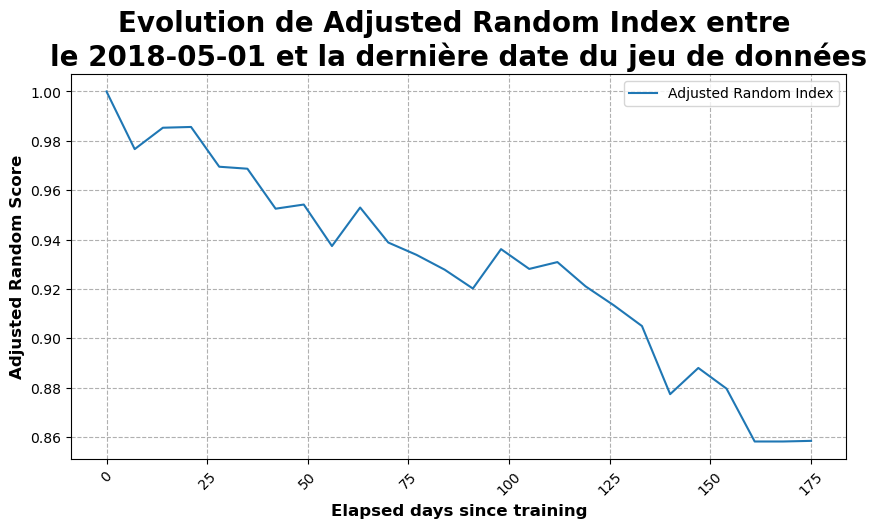

In [11]:
#Evolution de l'ARI en fonction du temps

plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size' : 10})

plt.plot(fa_ARI_track['Elapsed'], 
         fa_ARI_track['ARI'], 
         label = 'Adjusted Random Index')

x = plt.xticks(rotation = 45)

plt.title('Evolution de Adjusted Random Index entre \nle {} et la dernière date du jeu de données'.format(fa_ARI_track['dates'].values[0]),
          size = 20,
         weight = 'bold')

plt.grid(True, ls = '--')
plt.legend()

plt.xlabel('Elapsed days since training', 
           size = 12, 
           weight = 'bold')

plt.ylabel('Adjusted Random Score', 
           size = 12, 
           weight = 'bold')

## 3.2- Features RFM et KMeans 4-clusters

In [12]:
#Définition de la fonction ARI_calculator utilisant l'algorithme KMeans avec 4 clusters sur les features RFM

def ARI_calculator(orders, customers, order_payments, date, step):
#Initialisation des listes et variables 
    ARI = []
    Dates = []
    elapsed = []
    days_count = 0
    elapsed.append(days_count)
    Most_Recent_Date = orders['order_purchase_timestamp'].max()

#Construction du jeu de données RFM à la date de référence
    df = RFM_builder(orders, customers, order_payments, date)

#Pre-processing
    std = StandardScaler()
    std.fit(df[df.columns[1:]])
    df[df.columns[1:]] = std.transform(df[df.columns[1:]])

#KMeans
    km = KMeans(n_clusters = 4)
    km.fit(df[df.columns[1:]])
    first_labels = km.labels_
    
    Dates.append(datetime.strptime(date, '%y/%m/%d %H:%M:%S'))
    ARI.append(adjusted_rand_score(first_labels, first_labels))
    
    step = timedelta(step)
    d1 = datetime.strptime(date, '%y/%m/%d %H:%M:%S')
    
    while d1 < Most_Recent_Date:
        days_count += step.days
        elapsed.append(days_count)
        d1 = d1 + step
        Dates.append(d1)
        
        temp = RFM_builder(orders, customers, order_payments, datetime.strftime(d1, '%y/%m/%d %H:%M:%S'))
        temp[temp.columns[1:]] = std.transform(temp[temp.columns[1:]])
        
        new_labels = km.predict(temp[temp.columns[1:]])
        
        km2 = KMeans(n_clusters = 4)
        km2.fit(temp[temp.columns[1:]])
        second_labels = km2.labels_
#Calcul de l'ARI    
        new_ARI = adjusted_rand_score(second_labels, new_labels)
        ARI.append(new_ARI)
    
    final_df = pd.DataFrame({'dates' : Dates, 'ARI' : ARI, 'Elapsed' : elapsed})
    final_df['dates'] = final_df['dates'].astype(str)
    
    return final_df

In [13]:
#Essai avec une date de départ au 1er Mai 2018, avec un step de 7 jours

ARI_track = ARI_calculator(orders, customers, order_payments, '18/05/01 00:00:00', 7)
ARI_track.head()

,dates,ARI,Elapsed
0,2018-05-01,1.000000,0
1,2018-05-08,0.968406,7
2,2018-05-15,0.955836,14
3,2018-05-22,0.943584,21
4,2018-05-29,0.918454,28


Text(0, 0.5, 'Adjusted Random Score')

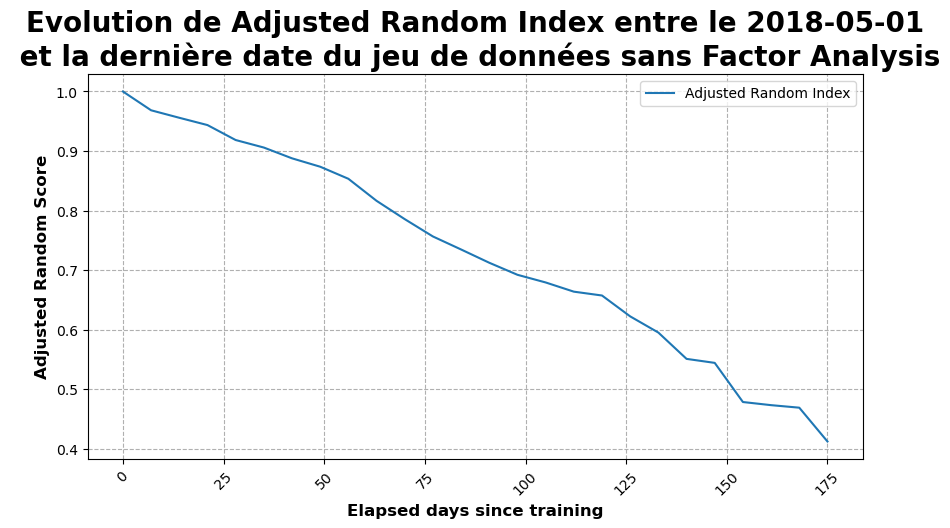

In [14]:
#Evolution de l'ARI en fonction du temps

plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size' : 10})

plt.plot(ARI_track['Elapsed'], 
         ARI_track['ARI'], 
         label = 'Adjusted Random Index')
x = plt.xticks(rotation = 45)

plt.title('Evolution de Adjusted Random Index entre le {}\n et la dernière date du jeu de données sans Factor Analysis'.format(ARI_track['dates'][0]), size = 20,
         weight = 'bold')
plt.grid(True, ls = '--')
plt.legend()

plt.xlabel('Elapsed days since training', 
           size = 12, 
           weight = 'bold')

plt.ylabel('Adjusted Random Score', 
           size = 12, 
           weight = 'bold')

# 4- Recherche du délai de mise à jour en fonction de la date initiale

In [15]:
#On place les dates du jeu de données avec un écart de 7 jours dans une liste

liste = ARI_calculator(orders, customers, order_payments, '17/01/01 00:00:00', 7)
liste['dates'] = liste['dates'].astype(str)

for i in liste.index:
    h = liste.loc[liste.index == i, 'dates'].values[0]
    liste.loc[liste.index == i, 'dates'] = h[2:4] + '/' + h[5:7] + '/' + h[8:10] + ' 00:00:00'

dates = liste['dates'].values

C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Window

In [16]:
#Pour chaque date du jeu de données, on récupère le temps mis par l'ARI pour passer sous la bar des 0.9, et on place
#ce temps dans une liste 'time'

time = []

for i in dates:
    temp = ARI_calculator(orders, customers, order_payments, i, 7)
    temp = temp.loc[temp['ARI']<0.9]
    h = temp['Elapsed'].min() - 1
    time.append(h)

C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\eyoun\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Window

In [17]:
#On place les jours-mois-années des dates dans une liste

dates_2 = []
for i in dates:
    dates_2.append(i[:8])

Text(0, 0.5, 'Number of days before update')

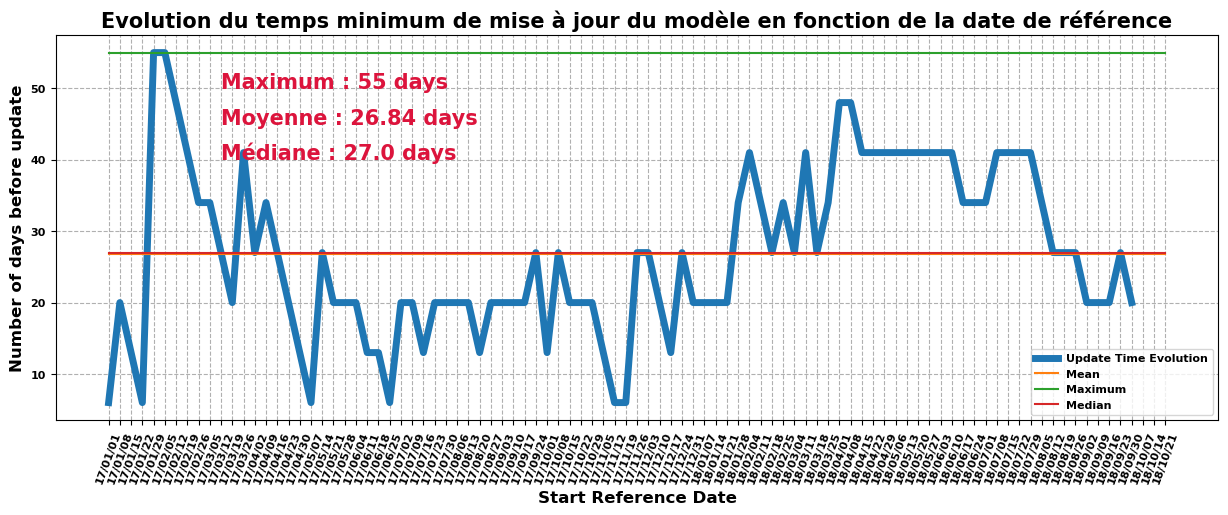

In [18]:
#On affiche le temps minimum pris par le modèle pour passer sous le seuil de 0.9

plt.rcParams.update({'font.size' : 8, 'font.weight' : 'bold'})
plt.figure(figsize = (15, 5))

plt.plot(dates_2, 
         time, 
         label = 'Update Time Evolution', 
         lw = 5)
h = plt.xticks(rotation = 70)

plt.title('Evolution du temps minimum de mise à jour du modèle en fonction de la date de référence', 
          weight = 'bold',
         size = 15)

plt.grid(True, ls = '--')
plt.text(10, 50, 'Maximum : {} days'.format(np.max(time[:-3])), 
         color = 'crimson', 
         weight = 'bold', 
         size = 15)

plt.text(10, 45, 'Moyenne : {} days'.format(str(np.mean(time[:-3]))[:5]), 
         color = 'crimson', 
         weight = 'bold', 
         size = 15)

plt.text(10, 40, 'Médiane : {} days'.format(str(np.median(time[:-3]))[:5]), 
         color = 'crimson', 
         weight = 'bold', 
         size = 15)

plt.plot(dates_2, np.full((len(time), 1), 
                          np.mean(time[:-3])),
         label = 'Mean')

plt.plot(dates_2, np.full((len(time), 1), 
                          np.max(time[:-3])), 
         label = 'Maximum')

plt.plot(dates_2, np.full((len(time), 1), np.median(time[:-3])), 
         label = 'Median')

plt.legend()

plt.xlabel('Start Reference Date',
           size = 12, 
           weight = 'bold')

plt.ylabel('Number of days before update', 
           size = 12, 
           weight = 'bold')

# 5- Conclusions